# Gender Classification Using VGG16+CNN


 We built a Gender (male Or female) classification model with VVG16 + convolutional neural network with 202419 images.


<img src="http://img.youtube.com/vi/TWWsW1w-BVo/0.jpg" width="800px">


# What is VGG16 model?
VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. ... By only keeping the convolutional modules, our model can be adapted to arbitrary input sizes. The model loads a set of weights pre-trained on ImageNet.

<img src="https://storage.googleapis.com/lds-media/images/vgg16-architecture.original.jpg" width="800px">


In [2]:
# Importing the layers module from TensorFlow's Keras API, which provides building blocks for creating neural network architectures.
from tensorflow.keras import layers

# Importing the ImageDataGenerator class to augment image data and create batches of tensor image data.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing TensorFlow, which is a comprehensive library for machine learning and deep learning.
import tensorflow as tf

# Importing callback functions:
# - ReduceLROnPlateau: Reduces learning rate when a metric has stopped improving.
# - EarlyStopping: Stops training when performance stops improving, avoiding overfitting.
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Importing the Sequential model class, which allows for linear stacking of layers to create neural networks.
from tensorflow.keras.models import Sequential

# Importing specific layers to use in the model:
# - Dense: Fully connected layer.
# - Conv2D: Convolutional layer for processing image data.
# - Flatten: Converts multi-dimensional tensor data into a single vector.
# - MaxPooling2D: Down-samples the feature maps, reducing their dimensions while preserving important features.
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Importing BatchNormalization, a layer that normalizes and scales input to stabilize learning and speed up convergence.
from keras.layers import BatchNormalization

# Importing the Adam optimizer, a popular choice for gradient-based optimization in deep learning models.
from keras.optimizers import Adam


In [2]:
# Creating an instance of ImageDataGenerator for preprocessing and augmenting training image data.
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescales pixel values to the range [0, 1] (originally [0, 255]).
    rotation_range=25,         # Randomly rotates images within a range of ±25 degrees.
    width_shift_range=0.2,     # Randomly shifts the image horizontally by up to 20% of its width.
    height_shift_range=0.2,    # Randomly shifts the image vertically by up to 20% of its height.
    shear_range=0.2,           # Applies random shear transformations with a magnitude of 0.2.
    zoom_range=0.2,            # Randomly zooms into images by up to 20%.
    horizontal_flip=True,      # Randomly flips images horizontally.
    fill_mode='nearest'        # Fills in missing pixels after transformations using the nearest pixel values.
)


In [3]:
# Batch size for training. Determines the number of samples per gradient update.
batch_size = 64

# Target size for input images. Images will be resized to 256x256 pixels.
target_size = (256, 256)

# Input shape for the neural network. Specifies height, width, and number of channels (3 for RGB).
input_shape = (256, 256, 3)

# Seed for random number generators. Ensures reproducibility of results.
seed = 1337

# Learning rate for the Adam optimizer. A lower value often provides more stable training.
adam = 0.001

#The fre variable determines how many layers of the base_model are frozen
fre = -20

# Number of neurons in the fully connected (FC) layer. Typically used for a dense layer before output.
FC = 2048

# Epoch multiplier or flag (usage depends on context). E = 1 likely refers to one full pass through the dataset.
E = 1

# Patience parameter for callbacks like EarlyStopping. Stops training after 3 epochs without improvement.
patience = 3

# Verbosity level for output logs during training (1 = progress bar, 0 = silent, 2 = one line per epoch).
verbose = 1

# Factor by which the learning rate is reduced when a metric has stopped improving. Halves the learning rate in this case.
factor = 0.50

# Minimum learning rate allowed during training. Prevents learning rate from being reduced indefinitely.
min_lr = 0.0001

# Number of steps (batches) to run per training epoch. Typically equals the number of training samples divided by batch size.
steps_per_epoch = 256

# Number of steps (batches) to run for validation at the end of each epoch.
validation_steps = 256

# Number of epochs for training. Represents the total number of complete passes through the training dataset.
epochs = 8


In [4]:
# Creating an ImageDataGenerator instance for the test/validation data.
# Only rescaling is applied here to normalize pixel values to the range [0, 1].
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generating augmented training data from the specified directory.
train_generator = train_datagen.flow_from_directory(
    '../input/gender-dataset/Dataset/Train',  # Path to the training dataset directory.
    batch_size=batch_size,                   # Number of images per batch.
    class_mode='binary',                     # Specifies binary classification (e.g., male vs. female).
    seed=seed,                               # Ensures reproducibility by using the same random seed.
    target_size=target_size                  # Resizes all images to the specified dimensions (256x256).
)

# Generating validation data from the specified directory.
validation_generator = test_datagen.flow_from_directory(
    '../input/gender-dataset/Dataset/Validation',  # Path to the validation dataset directory.
    batch_size=batch_size,                        # Number of images per batch.
    class_mode='binary',                          # Specifies binary classification.
    seed=seed,                                    # Ensures reproducibility for validation data.
    target_size=target_size                       # Resizes all images to the specified dimensions (256x256).
)


Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [5]:
# Loading the VGG16 pre-trained model as the base model for transfer learning.
base_model = tf.keras.applications.VGG16(
    input_shape=input_shape,  # Specifies the input dimensions (256x256 pixels, 3 color channels).
    include_top=False,       # Excludes the fully connected layers (top) of the original VGG16 model.
    weights="imagenet"       # Loads weights pre-trained on the ImageNet dataset.
)


In [6]:
# Freezing the layers of the base model to prevent them from being updated during training.
#This loop freezes all layers except the last 20, making those last layers trainable.
for layer in base_model.layers[:fre]:  
    layer.trainable = False  # Locks the weights of the selected layers.


In [7]:
# Building Model
model = Sequential()  # Initialize a sequential model

# Add the base model (VGG16 pre-trained model used for feature extraction)
model.add(base_model)  # `base_model` is typically a pre-trained model like VGG16, used as a feature extractor.

# Add a dropout layer to prevent overfitting
model.add(layers.Dropout(0.2))  # Drops 20% of neurons randomly during training to reduce overfitting.

# Add convolutional and normalization layers for further processing
model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same'))  
# Conv2D layer with 512 filters, 3x3 kernel, ReLU activation, and 'same' padding for feature extraction.
model.add(BatchNormalization())  # Normalizes the outputs of the Conv2D layer to improve convergence.
model.add(layers.Dropout(0.1))  # Adds 10% dropout to reduce overfitting.

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same'))  
# Conv2D layer with 128 filters, smaller number of filters for focusing on mid-level features.
model.add(BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'))  
# Conv2D with 384 filters, further deepens the network to capture complex patterns.
model.add(BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'))  
# Another Conv2D with the same configuration to refine the learned features.
model.add(BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(Conv2D(500, (3, 3), strides=(1, 1), activation='relu', padding='same'))  
# Final Conv2D layer with 500 filters to extract the most complex features.
model.add(BatchNormalization())

# Add max pooling to reduce spatial dimensions and retain key features
model.add(MaxPooling2D(2, strides=(2, 2), padding='same'))  
# Pooling with a 2x2 window to downsample the feature maps, preserving spatial structure.

# Flatten the feature maps into a 1D array for the fully connected layers
model.add(Flatten())  # Converts the 2D feature maps into a 1D vector for the dense layers.

# Add dense (fully connected) layers
model.add(Dense(FC, activation='relu'))  # Fully connected layer with ReLU activation.
model.add(layers.Dropout(0.2))  # 20% dropout to reduce overfitting.

model.add(Dense(FC, activation='relu'))  # Another dense layer to deepen the network.
model.add(layers.Dropout(0.2))

model.add(Dense(FC, activation='relu'))  # Third dense layer for additional learning capacity.
model.add(layers.Dropout(0.2))

# Final output layer
model.add(Dense(E, activation='sigmoid'))  
# Final dense layer with E neurons (output classes) and sigmoid activation for binary classification.

# Print a summary of the model architecture
model.summary()  # Displays all layers, parameters, and output shapes.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 512)         2359808   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         589952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         5

In [8]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

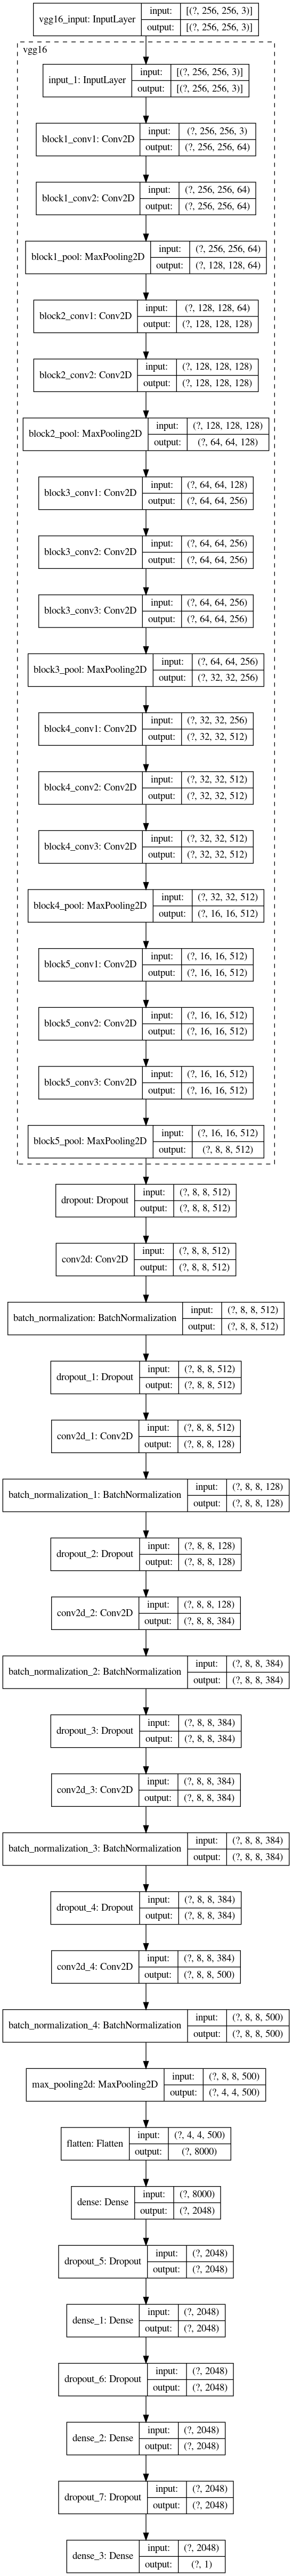

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [10]:
# Callback to reduce the learning rate when validation loss stops improving
lrd = ReduceLROnPlateau(
    monitor='val_loss',  # Monitors the validation loss during training.
    patience=patience,   # Number of epochs to wait before reducing the learning rate if no improvement.
    verbose=verbose,     # Controls the verbosity of the output; if True, logs when the learning rate changes.
    factor=factor,       # Factor by which the learning rate will be reduced (new_lr = current_lr * factor).
    min_lr=min_lr        # Lower bound for the learning rate, ensuring it doesn't drop too low.
)

# Callback to stop training early if the validation loss stops improving
es = EarlyStopping(
    verbose=verbose,     # If True, prints a message when training is stopped early.
    patience=patience    # Number of epochs to wait for improvement in the monitored metric (e.g., val_loss).
)


In [11]:
# Train the model using a generator for data feeding
hist = model.fit_generator(
    generator=train_generator,       # The generator that provides batches of training data.
    validation_data=validation_generator,  # The generator that provides batches of validation data.
    steps_per_epoch=steps_per_epoch, # Number of training batches to process per epoch.
    validation_steps=validation_steps, # Number of validation batches to process per epoch.
    epochs=epochs,                   # Total number of epochs for training.
    callbacks=[lrd, es]              # List of callbacks to optimize the training process.
)


Epoch 1/8
256/256 [==============================] - 320s 1s/step - loss: 1.0997 - accuracy: 0.6489 - val_loss: 1.1076 - val_accuracy: 0.4230
Epoch 2/8
256/256 [==============================] - 316s 1s/step - loss: 0.5388 - accuracy: 0.7415 - val_loss: 0.5133 - val_accuracy: 0.7527
Epoch 3/8
256/256 [==============================] - 333s 1s/step - loss: 0.4684 - accuracy: 0.7875 - val_loss: 0.3970 - val_accuracy: 0.8365
Epoch 4/8
256/256 [==============================] - 330s 1s/step - loss: 0.3153 - accuracy: 0.8661 - val_loss: 0.2234 - val_accuracy: 0.9154
Epoch 5/8
256/256 [==============================] - 330s 1s/step - loss: 0.2605 - accuracy: 0.8975 - val_loss: 0.1810 - val_accuracy: 0.9307
Epoch 6/8
256/256 [==============================] - 325s 1s/step - loss: 0.2325 - accuracy: 0.9128 - val_loss: 0.1662 - val_accuracy: 0.9359
Epoch 7/8
256/256 [==============================] - 329s 1s/step - loss: 0.2180 - accuracy: 0.9189 - val_loss: 0.3282 - val_accuracy: 0.8687
Epoch 

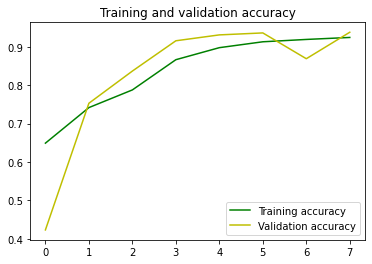

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting

# Extracting accuracy and loss metrics from the training history
acc = hist.history['accuracy']          # Training accuracy for each epoch
val_acc = hist.history['val_accuracy']  # Validation accuracy for each epoch
loss = hist.history['loss']             # Training loss for each epoch
val_loss = hist.history['val_loss']     # Validation loss for each epoch

# Define the range of epochs
epochs = range(len(acc))  # A range object representing the number of epochs

# Plot training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')  # Plot training accuracy (green line)
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')  # Plot validation accuracy (yellow line)
plt.title('Training and validation accuracy')  # Add a title to the plot
plt.legend(loc=0)  # Add a legend (location 0: best position automatically)
plt.figure()  # Create a new figure for additional plots (optional)
plt.show()  # Display the plot


[1.]
This  is a female


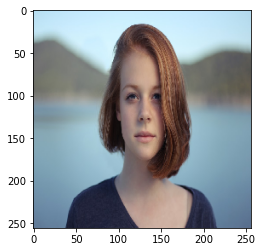

In [13]:
import numpy as np  # Import NumPy for numerical operations
from keras.preprocessing import image  # For image preprocessing and loading

# Path to the test image
path_testmodel = "../input/testmodel/test1.jpg"  # Replace with the correct path to the test image

# Load and preprocess the image
imge = image.load_img(path_testmodel, target_size=target_size)  
# Load the image from the specified path and resize it to the target size of the model's input.

X = image.img_to_array(imge)  
# Convert the PIL image to a NumPy array of shape (target_size[0], target_size[1], 3).

X = np.expand_dims(X, axis=0)  
# Expand the array to have a batch dimension (1, target_size[0], target_size[1], 3).

# Prepare the image for prediction
images = np.vstack([X])  
# Vertically stack the image array into a batch. Useful if you have multiple images.

# Predict the class using the trained model
classes = model.predict(images, batch_size=1)  
# Predict the class probabilities for the batch of images.

# Display the predicted class
print(classes[0])  
# Print the prediction for the first image in the batch.

# Interpret the prediction
if classes[0] < 0.5:  
    print("This is a male")  # Output "male" for predictions below 0.5
else:
    print("This is a female")  # Output "female" for predictions 0.5 or above.

# Display the test image
plt.imshow(imge)  
# Visualize the image using Matplotlib.


[0.]
This is a male


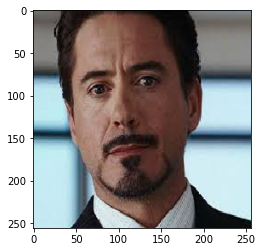

In [21]:
# Path to the test image
path_testmodel = "/kaggle/input/testmodel/test2.jpg"  
# Define the path to the test image. Ensure the path exists.

# Load the image
imge = image.load_img(path_testmodel, target_size=target_size)  
# Load the image from the specified path and resize it to the target size of the model's input.

# Convert the image to a NumPy array
X = image.img_to_array(imge)  
# Convert the loaded image into a NumPy array of shape (target_size[0], target_size[1], 3).

# Add a batch dimension
X = np.expand_dims(X, axis=0)  
# Expand the dimensions to include a batch size, resulting in shape (1, target_size[0], target_size[1], 3).

# Prepare the image for batch prediction
images = np.vstack([X])  
# Stack the image into a batch. This is helpful for consistency when working with multiple images.

# Make a prediction
classes = model.predict(images, batch_size=1)  
# Use the trained model to predict the class. The output will be a probability for each image in the batch.

# Print the class probabilities
print(classes[0])  
# Display the prediction for the first (and only) image in the batch.

# Interpret the prediction
if classes[0] < 0.5:  
    print("This is a male")  # Classify as "male" if the predicted value is below 0.5.
else:
    print("This is a female")  # Classify as "female" if the predicted value is 0.5 or above.

# Display the test image
plt.imshow(imge)  
# Visualize the image using Matplotlib.
plt.title("Male" if classes[0] < 0.5 else "Female")  
# Add a title to the plot to display the classification result.
plt.axis('off')  # Hide axes for cleaner visualization.
plt.show()  # Show the image and classification.


In [15]:
test =  test_datagen.flow_from_directory( '/kaggle/input/gender-dataset/Dataset/Test',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 20001 images belonging to 2 classes.


In [16]:
model.evaluate(test)

313/313 [==============================] - 71s 228ms/step - loss: 0.1560 - accuracy: 0.9416


[0.1560330092906952, 0.9416029453277588]

In [17]:
model.save('gender_model.h5')